In [ ]:
import os
from os import path

#  Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
figure_path = 'figures'
os.makedirs(figure_path, exist_ok=True)

In [ ]:
# global settings
figsize = (6.66, 5)

line_style = dict(marker='', linewidth=3, linestyle='-')

## Wide binary velocity

In [ ]:
from astropy.constants import G

In [ ]:
M = 2 * u.Msun
a = np.logspace(-4, 1, 1024) * u.pc
vorb = np.sqrt(G*M / a)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax2 = ax.twiny()

ax.plot(a, vorb.to(u.km/u.s).value, **line_style)

ax.text(5E-4, 6, r'$M_{{\rm tot}} =$ {0.value} {0.unit:latex_inline}'.format(M), fontsize=20)

ax.set_xlim(a.to(u.pc).value.min(), a.to(u.pc).value.max())
ax.set_ylim(-0.5, 10)
ax.set_xscale('log')
ax.set_xlabel('$a$ [pc]', labelpad=10)
ax.set_ylabel('orbital\nvelocity\n[{0:latex_inline}]'.format(u.km/u.s), 
              rotation='horizontal', ha='right', va='center', labelpad=10)

ax2.set_xlim(a.to(u.au).value.min(), a.to(u.au).value.max())
ax2.set_xscale('log')
ax2.set_xlabel('$a$ [AU]', labelpad=10)

fig.tight_layout()
fig.savefig(path.join(figure_path, 'binary_vel.pdf'))

---

## Jacobi radius

In [ ]:
from matplotlib.ticker import FormatStrFormatter
import gala.potential as gp

In [ ]:
pot = gp.MilkyWayPotential()

In [ ]:
M = 2*u.Msun
xyz = np.zeros((3, 1024)) * u.kpc
xyz[0] = np.linspace(0.1, 30, xyz.shape[1]) * u.kpc
M_enc = pot.mass_enclosed(xyz)

r_jac = (M / (3*M_enc))**(1/3.) * xyz[0]

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(xyz[0], r_jac.to(u.pc).value, **line_style)
ax.set_yscale('log')
ax.set_xlim(4, 30)
ax.set_ylim(0.7, 7)

ax.set_xlabel('Galactocentric $r$ [kpc]')
ax.set_ylabel('Jacobi\nradius\n[pc]', 
              rotation='horizontal', ha='right', va='center', labelpad=10)

ax.yaxis.set_ticks(range(1,5+1), minor=True)
ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))
ax.yaxis.set_ticklabels([''])

ax.grid(which='minor')

fig.tight_layout()
fig.savefig(path.join(figure_path, 'jacobi_radius.pdf'))

## RG-MS pairs

In [91]:
from astropy.table import Table
from matplotlib.animation import FuncAnimation

tbl1 = Table.read('../../gaia-comoving-stars/paper/t1-1-star.txt', format='ascii.csv')
tbl2 = Table.read('../../gaia-comoving-stars/paper/t1-2-pair.txt', format='ascii.csv')
tbl3 = Table.read('../../gaia-comoving-stars/paper/t1-3-group.txt', format='ascii.csv')

star1 = tbl1[tbl2['star1']]
star2 = tbl1[tbl2['star2']]

In [92]:
M_G = tbl1['G'] - 5*np.log10(tbl1['distance'] / (10.))
G_J = tbl1['G'] - tbl1['J']

In [93]:
def giant_mask(G_J, M_G):
    mask = G_J > 1
    
    sub_cut = (G_J > 1) & (G_J < 1.6)
    mask[sub_cut] &= (M_G[sub_cut] < (5*(G_J[sub_cut] - 1) + 1.))
    
    sub_cut = (G_J > 1.6)
    mask[sub_cut] &= (M_G[sub_cut] < (0.5*(G_J[sub_cut] - 1) + 1.))
    
    return mask

/Users/adrian/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/adrian/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)


(-0.25, 2.25)

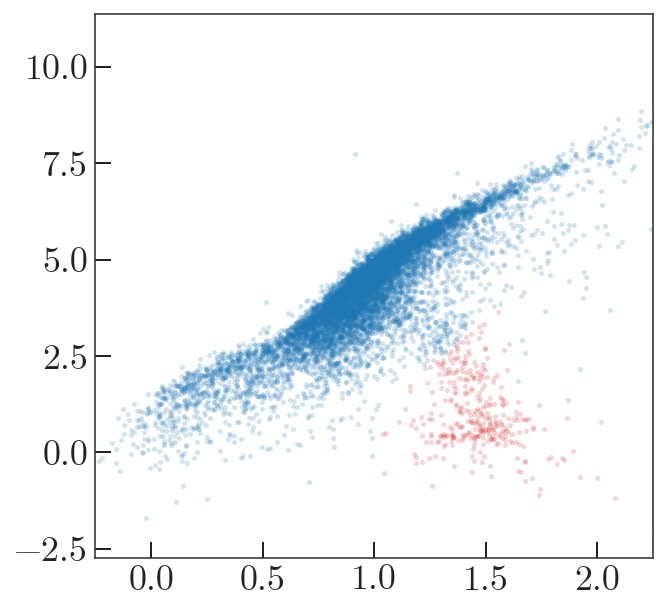

In [94]:
plt.figure(figsize=(5,5))

giants = giant_mask(G_J, M_G)
plt.plot(G_J[giants], M_G[giants], color='tab:red', 
         marker='.', alpha=0.2, linestyle='none')
plt.plot(G_J[~giants], M_G[~giants], color='tab:blue', 
         marker='.', alpha=0.2, linestyle='none')
plt.xlim(-0.25, 2.25)
# plt.ylim(8.5, -1.5)

In [101]:
giant_gid = tbl1[giants]['group_id']
ms_gid = tbl1[~giants]['group_id']

giant_ms_group_ids = giant_gid[np.in1d(giant_gid, ms_gid)]
print(len(giant_ms_group_ids))

g_ms_idx = np.in1d(tbl1['group_id'], giant_ms_group_ids)
_tbl1 = tbl1[g_ms_idx]

_idx = (np.in1d(tbl2['star1'], _tbl1['row_id']) & 
        np.in1d(tbl2['star2'], _tbl1['row_id']))
_tbl2 = tbl2[_idx]

star1_giant_ms = tbl1[_tbl2['star1']]
star2_giant_ms = tbl1[_tbl2['star2']]

307


In [102]:
giant_ms = tbl1[g_ms_idx]

GJ1 = star1_giant_ms['G'] - star1_giant_ms['J']
MG1 = star1_giant_ms['G'] - 5*np.log10(star1_giant_ms['distance'] / (10.))

GJ2 = star2_giant_ms['G'] - star2_giant_ms['J']
MG2 = star2_giant_ms['G'] - 5*np.log10(star2_giant_ms['distance'] / (10.))

gm_GJ = giant_ms['G'] - giant_ms['J']
gm_MG = giant_ms['G'] - 5*np.log10(giant_ms['distance'] / (10.))
_giants = giant_mask(gm_GJ, gm_MG)

/Users/adrian/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/adrian/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)


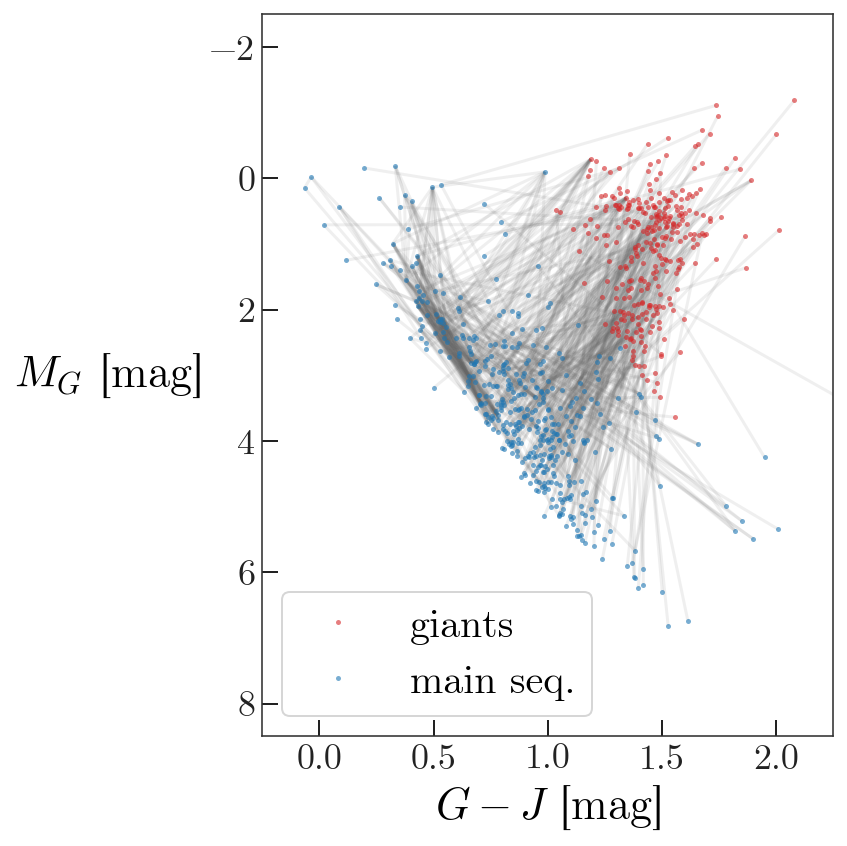

In [113]:
fig,ax = plt.subplots(1, 1, figsize=(6,6))

lines = []
for i in range(len(star1_giant_ms)):
    lines.append([(GJ1[i], MG1[i]), 
                  (GJ2[i], MG2[i])])
    
lc = mpl.collections.LineCollection(lines, linestyles='-', zorder=-100,
                                    alpha=0.1, color='#666666')
ax.add_collection(lc)
    
ax.plot(gm_GJ[_giants], gm_MG[_giants], color='tab:red', 
        marker='.', alpha=0.6, linestyle='none', label='giants')

ax.plot(gm_GJ[~_giants], gm_MG[~_giants], color='tab:blue', 
        marker='.', alpha=0.6, linestyle='none', label='main seq.')

ax.set_xlim(-0.25, 2.25)
ax.set_ylim(8.5, -2.5)

ax.legend(loc='lower left', fontsize=20)

ax.set_xlabel('$G-J$ [mag]')
ax.set_ylabel('$M_G$ [mag]', rotation='horizontal', va='center', ha='right')
fig.tight_layout()

fig.savefig(path.join(figure_path, 'giant-ms-pairs.pdf'))

---

## Geometric velocity effects

In [ ]:
from scipy.stats import binned_statistic, scoreatpercentile

In [ ]:
def get_isotropic_angles(size=1):
    phi = np.random.uniform(0, 360, size=N) * u.deg
    theta = np.arccos(2*np.random.uniform(size=N) - 1) * u.rad
    return {'phi': phi, 'theta': theta}

In [ ]:
def get_stats(dx, v_mag, size, n_bins=16):
    # First make a bunch of isotropic, uniform comoving pairs within a sphere
    r = 200*u.pc * np.cbrt(np.random.uniform(size=N))
    pos1 = coord.PhysicsSphericalRepresentation(r=r, **get_isotropic_angles(size=N))

    r = dx * np.ones(N)
    pos2 = pos1 + coord.PhysicsSphericalRepresentation(r=r, **get_isotropic_angles(size=N)) 

    v_basis = coord.PhysicsSphericalRepresentation(r=np.ones(N), **get_isotropic_angles(size=N)) 
    v_basis = v_basis.represent_as(coord.CartesianRepresentation).xyz
    v = coord.CartesianDifferential(v_mag * v_basis)

    icrs1 = coord.ICRS(pos1.represent_as(coord.CartesianRepresentation)
                           .with_differentials(v))
    icrs2 = coord.ICRS(pos2.represent_as(coord.CartesianRepresentation)
                           .with_differentials(v))
    
    # compute ∆µ and ∆vtan
    dpm = np.sqrt((icrs1.pm_ra_cosdec-icrs2.pm_ra_cosdec)**2 + (icrs1.pm_dec - icrs2.pm_dec)**2)
    dvtan = (dpm * icrs1.distance).to(u.km/u.s, u.dimensionless_angles())
    
    # compute binned stats
    bins = np.linspace(0, 200+(200/n_bins/2), n_bins)
    
    res = dict(dpm=[], dvtan=[])
    res['dpm'].append(binned_statistic(icrs1.distance.to(u.pc).value, 
                                       dpm.to(u.mas/u.yr).value, 
                                       bins=bins, statistic=np.median))
    res['dpm'].append(binned_statistic(icrs1.distance.to(u.pc).value, 
                                       dpm.to(u.mas/u.yr).value, 
                                       bins=bins, statistic=lambda x: scoreatpercentile(x, 5)))
    res['dpm'].append(binned_statistic(icrs1.distance.to(u.pc).value, 
                                       dpm.to(u.mas/u.yr).value, 
                                       bins=bins, statistic=lambda x: scoreatpercentile(x, 95)))
    
    res['dvtan'].append(binned_statistic(icrs1.distance.to(u.pc).value, 
                                         dvtan.value, 
                                         bins=bins, statistic=np.median))
    res['dvtan'].append(binned_statistic(icrs1.distance.to(u.pc).value, 
                                         dvtan.value, 
                                         bins=bins, statistic=lambda x: scoreatpercentile(x, 5)))
    res['dvtan'].append(binned_statistic(icrs1.distance.to(u.pc).value, 
                                         dvtan.value, 
                                         bins=bins, statistic=lambda x: scoreatpercentile(x, 95)))
    
    res['x'] = 0.5 * (bins[1:] + bins[:-1])
    
    return res

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

In [ ]:
fig,axes = plt.subplots(2, 1, figsize=(6,8), sharex=True)

for i,v in enumerate([100, 30, 5]*u.km/u.s):
    stats = get_stats(dx=1*u.pc, v_mag=v, size=1E6, n_bins=21)
    for j,name in enumerate(['dpm', 'dvtan']):
        axes[j].plot(stats['x'], stats[name][0].statistic, 
                     label='$v-v_\odot = {0.value:.0f}$ {0.unit:latex_inline}'.format(v),
                     marker='', linestyle='-', linewidth=2, color=colors[i], zorder=10)
        axes[j].fill_between(stats['x'], stats[name][1].statistic, stats[name][2].statistic,
                             color=colors[i], alpha=0.5, zorder=1, linewidth=0)
    
axes[0].set_yscale('log')
axes[0].set_ylim(1E-2, 1E2)
axes[0].set_yticks(10. ** np.arange(-2, 2+1, 1))
axes[0].set_yticklabels([0.01, 0.1, 1, 10, 100])
axes[0].set_ylabel(r'$|\Delta\bar{{\mu}}|$ [{0:latex_inline}]'.format(u.mas/u.yr))
axes[0].legend(loc='upper right', fontsize=14)
axes[0].set_title(r'$|\Delta\bar{x}| = 1$ [pc]', fontsize=22)

axes[1].set_yscale('log')
axes[1].set_ylim(1E-2, 5E1)
axes[1].set_xlim(0, 200)
axes[1].set_yticks(10. ** np.arange(-2, 1+1, 1))
axes[1].set_yticklabels([0.01, 0.1, 1, 10])
axes[1].set_ylabel(r'$|\Delta\bar{{v}}_{{\rm tan}}|$ [{0:latex_inline}]'.format(u.km/u.s))

axes[1].set_xlabel(r'distance, $d_\odot$ [{0}]'.format(u.pc))

fig.tight_layout()
fig.savefig(path.join(figure_path, 'dv-dist-fixed-sep.pdf'))

In [ ]:
fig,axes = plt.subplots(2, 1, figsize=(6,8), sharex=True)

for i,dx in enumerate([10, 1, 0.1]*u.pc):
    stats = get_stats(dx=dx, v_mag=30*u.km/u.s, size=1E6, n_bins=21)
    for j,name in enumerate(['dpm', 'dvtan']):
        label = r'$|\Delta\bar{{x}}| = {0.value:.0f}$ {0.unit:latex_inline}'.format(dx)
        if i == 2:
            label = r'$|\Delta\bar{{x}}| = {0.value:.1f}$ {0.unit:latex_inline}'.format(dx)
        axes[j].plot(stats['x'], stats[name][0].statistic, label=label,
                     marker='', linestyle='-', linewidth=2, color=colors[i], zorder=10)
        axes[j].fill_between(stats['x'], stats[name][1].statistic, stats[name][2].statistic,
                             color=colors[i], alpha=0.5, zorder=1, linewidth=0)
    
axes[0].set_yscale('log')
axes[0].set_ylim(5E-2, 5E2)
axes[0].set_yticks(10. ** np.arange(-2, 2+1, 1))
axes[0].set_yticklabels([0.01, 0.1, 1, 10, 100])
axes[0].set_ylabel(r'$|\Delta\bar{{\mu}}|$ [{0:latex_inline}]'.format(u.mas/u.yr))
axes[0].legend(loc='upper right', fontsize=14)
axes[0].set_title(r'$v-v_\odot = 30$ [{0:latex_inline}]'.format(u.km/u.s), fontsize=22)

axes[1].set_yscale('log')
axes[1].set_ylim(1E-2, 5E1)
axes[1].set_xlim(0, 200)
axes[1].set_yticks(10. ** np.arange(-2, 1+1, 1))
axes[1].set_yticklabels([0.01, 0.1, 1, 10])
axes[1].set_ylabel(r'$|\Delta\bar{{v}}_{{\rm tan}}|$ [{0:latex_inline}]'.format(u.km/u.s))

axes[1].set_xlabel(r'distance, $d_\odot$ [{0}]'.format(u.pc))

fig.tight_layout()
fig.savefig(path.join(figure_path, 'dv-dist-fixed-dv.pdf'))

---

## Gaia proper motion precision

In [ ]:
from pygaia.photometry.utils import vminiFromSpt
from pygaia.errors.astrometric import properMotionErrorSkyAvg

In [ ]:
sun_mag = 4.83
d = 1 * u.kpc
G = 5 * np.log10(d / (10*u.pc)) + sun_mag
print(G)

In [ ]:
v = 25 * u.km/u.s
pm = (v / d).to(u.microarcsecond/u.yr, u.dimensionless_angles())
pm_err = np.linalg.norm(properMotionErrorSkyAvg(G, vminiFromSpt('G5V'))) * u.microarcsecond/u.yr

n_samples = 10000
d_samples = np.random.normal(d.value, 0.02, size=n_samples) * u.kpc
pm_samples = np.random.normal(pm.value, pm_err.value, size=n_samples) * u.microarcsecond/u.yr
v_samples = (pm_samples * d_samples).to(u.km/u.s, u.dimensionless_angles())
print(np.std(v_samples))

In [ ]:
G_grid = np.linspace(6, 20, 1024)
vmini = vminiFromSpt('B0V')
pm_err = np.linalg.norm(properMotionErrorSkyAvg(G_grid, vmini), axis=0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.2))

ax.fill_between(G_grid, pm_err - 0.3*pm_err, pm_err + 0.08*pm_err, 
                zorder=100, alpha=0.6)

ax.set_yscale('log')
ax.set_xlim(6, 20)
ax.set_ylim(1, 1000)

ax.grid(which='both')
fig.savefig(path.join(figure_path, 'gaia-pm-err.pdf'))

---

## TGAS plots

In [ ]:
from astropy.io import fits
from astropy.table import Table

In [ ]:
tgas = Table(fits.getdata('/Users/adrian/projects/gaia-comoving-stars/data/stacked_tgas.fits'))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.hist(tgas['phot_g_mean_mag'], bins=np.linspace(4, 16, 128));
ax.set_yscale('log')
ax.set_xlabel('$G$ [mag]')
ax.set_ylabel('$N$ stars', rotation='horizontal', ha='right')
ax.set_xticks(range(4,16+1,2))
fig.tight_layout()
fig.savefig(path.join(figure_path, 'tgas-G-hist.pdf'))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

pm_err = np.sqrt(tgas['pmra_error']**2 + tgas['pmdec_error']**2)
H, xedg, yedg = np.histogram2d(tgas['phot_g_mean_mag'], np.log10(pm_err), 
                               bins=(np.linspace(6, 14, 128),
                                     np.linspace(-2, 2, 64)))

ax.pcolormesh(xedg, yedg, np.log10(H.T), 
              vmin=0, vmax=4, cmap='Blues',
              linewidth=0, rasterized=True)

ax.set_xlabel('$G$ [mag]')
ax.set_ylabel(r'$\sigma_\mu$' +'\n[{0:latex_inline}]'.format(u.mas/u.yr), 
              rotation='horizontal', ha='right', va='center')

ax.set_xlim(6, 14)
ax.set_ylim(-2, 2)

ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_yticklabels(["0.01", "0.1", "1", "10", "100"])

fig.tight_layout()
fig.savefig(path.join(figure_path, 'tgas-pm-err.pdf'))

---

## Graphical models

In [ ]:
import daft

In [ ]:
param_phys = {'ec':'#3182bd', 'lw':2}

with mpl.rc_context(rc={'font.size': 30}):
    pgm = daft.PGM([6, 4], node_unit=2.5, grid_unit=4)
    pgm.add_node(daft.Node("sigmap", r"$\sigma_\varpi$", 1, 3, aspect=1.))
    pgm.add_node(daft.Node("covpm", r"$\mathcal{C}$", 2.5, 3, aspect=1.))
    pgm.add_node(daft.Node("radec", r"$\alpha,\delta$", 3.5, 1.2, aspect=1., fixed=True, offset=[15,8]))
    pgm.add_node(daft.Node("parallax", r"$\varpi$", 1, 2, aspect=1., observed=True))
    pgm.add_node(daft.Node("pmra", r"$\mu_\alpha$", 2, 2, aspect=1., observed=True))
    pgm.add_node(daft.Node("pmdec", r"$\mu_\delta$", 3, 2, aspect=1., observed=True))
    pgm.add_node(daft.Node("distance", r"$r$", 1, 1, aspect=1., plot_params=param_phys))
    pgm.add_node(daft.Node("velocity", r"$\bar{v}$", 2.5, 1, aspect=1., plot_params=param_phys))

    pgm.add_edge("sigmap", "parallax")
    pgm.add_edge("covpm", "pmra")
    pgm.add_edge("covpm", "pmdec")
    pgm.add_edge("distance", "parallax")
    pgm.add_edge("distance", "pmra")
    pgm.add_edge("distance", "pmdec")
    pgm.add_edge("velocity", "pmra")
    pgm.add_edge("velocity", "pmdec")
    pgm.add_edge("radec", "pmra")
    pgm.add_edge("radec", "pmdec")
    
    pgm.render()
    pgm.figure.savefig(path.join(figure_path, 'pgm-1-star.pdf'))

In [ ]:
with mpl.rc_context(rc={'font.size': 30}):
    pgm = daft.PGM([6, 6], node_unit=2.5, grid_unit=4)
    pgm.add_node(daft.Node("sigmap1", r"$\sigma_{\varpi,1}$", 1, 5.5, aspect=1.))
    pgm.add_node(daft.Node("covpm1", r"$\mathcal{C}_1$", 2.5, 5.5, aspect=1.))
    pgm.add_node(daft.Node("radec1", r"$\alpha_1$, $\delta_1$", 3.5, 1.2+2.5, aspect=1., fixed=True, offset=[15,-40]))
    pgm.add_node(daft.Node("parallax1", r"$\varpi_1$", 1, 2+2.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("pmra1", r"$\mu_{\alpha,1}$", 2, 2+2.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("pmdec1", r"$\mu_{\delta,1}$", 3, 2+2.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("distance1", r"$r_1$", 1, 1+2.5, aspect=1., plot_params=param_phys))
    pgm.add_node(daft.Node("velocity", r"$\bar{v}$", 2.5, 3, aspect=1., plot_params=param_phys))

    pgm.add_node(daft.Node("sigmap2", r"$\sigma_{\varpi,2}$", 1, 0.5, aspect=1.))
    pgm.add_node(daft.Node("covpm2", r"$\mathcal{C}_2$", 2.5, 0.5, aspect=1.))
    pgm.add_node(daft.Node("radec2", r"$\alpha_2$, $\delta_2$", 3.5, 2.3, aspect=1., fixed=True, offset=[15,8]))
    pgm.add_node(daft.Node("parallax2", r"$\varpi_2$", 1, 1.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("pmra2", r"$\mu_{\alpha,2}$", 2, 1.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("pmdec2", r"$\mu_{\delta,2}$", 3, 1.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("distance2", r"$r_2$", 1, 2.5, aspect=1., plot_params=param_phys))

    pgm.add_edge("sigmap1", "parallax1")
    pgm.add_edge("distance1", "parallax1")
    pgm.add_edge("distance1", "pmra1")
    pgm.add_edge("distance1", "pmdec1")
    pgm.add_edge("covpm1", "pmra1")
    pgm.add_edge("covpm1", "pmdec1")
    pgm.add_edge("velocity", "pmra1")
    pgm.add_edge("velocity", "pmdec1")
    pgm.add_edge("radec1", "pmra1")
    pgm.add_edge("radec1", "pmdec1")

    pgm.add_edge("sigmap2", "parallax2")
    pgm.add_edge("distance2", "parallax2")
    pgm.add_edge("distance2", "pmra2")
    pgm.add_edge("distance2", "pmdec2")
    pgm.add_edge("covpm2", "pmra2")
    pgm.add_edge("covpm2", "pmdec2")
    pgm.add_edge("velocity", "pmra2")
    pgm.add_edge("velocity", "pmdec2")
    pgm.add_edge("radec2", "pmra2")
    pgm.add_edge("radec2", "pmdec2")

    pgm.render()
    pgm.figure.savefig(path.join(figure_path, 'pgm-case-1.pdf'))

In [ ]:
with mpl.rc_context(rc={'font.size': 30}):
    pgm = daft.PGM([6, 6], node_unit=2.5, grid_unit=4)
    pgm.add_node(daft.Node("sigmap1", r"$\sigma_{\varpi,1}$", 1, 5.5, aspect=1.))
    pgm.add_node(daft.Node("covpm1", r"$\mathcal{C}_1$", 2.5, 5.5, aspect=1.))
    pgm.add_node(daft.Node("radec1", r"$\alpha_1$, $\delta_1$", 3.5, 1.2+2.5, aspect=1., fixed=True, offset=[15,-40]))
    pgm.add_node(daft.Node("parallax1", r"$\varpi_1$", 1, 2+2.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("pmra1", r"$\mu_{\alpha,1}$", 2, 2+2.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("pmdec1", r"$\mu_{\delta,1}$", 3, 2+2.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("distance1", r"$r_1$", 1, 1+2.5, aspect=1., plot_params=param_phys))
    pgm.add_node(daft.Node("velocity1", r"$\bar{v}_1$", 2.5, 3.5, aspect=1., plot_params=param_phys))

    pgm.add_node(daft.Node("sigmap2", r"$\sigma_{\varpi,2}$", 1, 0.5, aspect=1.))
    pgm.add_node(daft.Node("covpm2", r"$\mathcal{C}_2$", 2.5, 0.5, aspect=1.))
    pgm.add_node(daft.Node("radec2", r"$\alpha_2$, $\delta_2$", 3.5, 2.3, aspect=1., fixed=True, offset=[15,8]))
    pgm.add_node(daft.Node("parallax2", r"$\varpi_2$", 1, 1.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("pmra2", r"$\mu_{\alpha,2}$", 2, 1.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("pmdec2", r"$\mu_{\delta,2}$", 3, 1.5, aspect=1., observed=True))
    pgm.add_node(daft.Node("distance2", r"$r_2$", 1, 2.5, aspect=1., plot_params=param_phys))
    pgm.add_node(daft.Node("velocity2", r"$\bar{v}_2$", 2.5, 2.5, aspect=1., plot_params=param_phys))

    pgm.add_edge("sigmap1", "parallax1")
    pgm.add_edge("distance1", "parallax1")
    pgm.add_edge("distance1", "pmra1")
    pgm.add_edge("distance1", "pmdec1")
    pgm.add_edge("covpm1", "pmra1")
    pgm.add_edge("covpm1", "pmdec1")
    pgm.add_edge("velocity1", "pmra1")
    pgm.add_edge("velocity1", "pmdec1")
    pgm.add_edge("radec1", "pmra1")
    pgm.add_edge("radec1", "pmdec1")

    pgm.add_edge("sigmap2", "parallax2")
    pgm.add_edge("distance2", "parallax2")
    pgm.add_edge("distance2", "pmra2")
    pgm.add_edge("distance2", "pmdec2")
    pgm.add_edge("covpm2", "pmra2")
    pgm.add_edge("covpm2", "pmdec2")
    pgm.add_edge("velocity2", "pmra2")
    pgm.add_edge("velocity2", "pmdec2")
    pgm.add_edge("radec2", "pmra2")
    pgm.add_edge("radec2", "pmdec2")

    pgm.render()
    pgm.figure.savefig(path.join(figure_path, 'pgm-case-2.pdf'))

---

## Pairs plots

In [ ]:
from astropy.table import Table
from matplotlib.animation import FuncAnimation

In [ ]:
from astropy.table import Table
from matplotlib.animation import FuncAnimation

tbl1 = Table.read('../../gaia-comoving-stars/paper/t1-1-star.txt', format='ascii.csv')
tbl2 = Table.read('../../gaia-comoving-stars/paper/t1-2-pair.txt', format='ascii.csv')
tbl3 = Table.read('../../gaia-comoving-stars/paper/t1-3-group.txt', format='ascii.csv')

In [ ]:
star1 = tbl1[tbl2['star1']]
star2 = tbl1[tbl2['star2']]

In [ ]:
star1_c = coord.ICRS(ra=star1['ra']*u.deg,
                     dec=star1['dec']*u.deg,
                     distance=star1['distance']*u.pc)

star2_c = coord.ICRS(ra=star2['ra']*u.deg,
                     dec=star2['dec']*u.deg,
                     distance=star2['distance']*u.pc)

star1_c = star1_c.transform_to(coord.Galactic)
star2_c = star2_c.transform_to(coord.Galactic)

In [ ]:
star1_xyz = star1_c.represent_as('cartesian').xyz.to(u.pc).value
star2_xyz = star2_c.represent_as('cartesian').xyz.to(u.pc).value

In [ ]:
lim = 200

fig,ax = plt.subplots(1, 1, figsize=(8,8))

lines = []
for i in range(len(star1)):
    lines.append([(star1_xyz[0,i], star1_xyz[2,i]),
                  (star2_xyz[0,i], star2_xyz[2,i])]) 

lc = mpl.collections.LineCollection(lines, linestyles='-', 
                                    alpha=0.2, color='k')
ax.add_collection(lc)

ax.text(0, 0, r'$\odot$', fontsize=18, 
        zorder=100, ha='center', va='center')
        
# For sanity checking:
ls = [0,90,180,270]
nodes = coord.Galactic(l=ls*u.deg, 
                       b=np.zeros(4)*u.deg,
                       distance=lim*u.pc).represent_as('cartesian').xyz.to(u.pc).value

for node,l in zip(nodes.T, ls):
    ax.plot([0,node[0]], [0, node[1]], marker='',
            lw=2, zorder=-100, alpha=0.1, color='#666666')
    ax.text(node[0], node[1], r'$l = {0}^\circ$'.format(l), va='top')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(8,8))

angles = np.arange(0, 360+1, 1)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.tight_layout()

def func(angle):
    R = coord.matrix_utilities.rotation_matrix(angle*u.deg, axis='x')
    new_star1_xyz = R @ star1_xyz
    new_star2_xyz = R @ star2_xyz
    
    lines = []
    for i in range(len(star1)):
        lines.append([(new_star1_xyz[0,i], new_star1_xyz[1,i]),
                      (new_star2_xyz[0,i], new_star2_xyz[1,i])]) 
    
    lc = mpl.collections.LineCollection(lines, linestyles='-', 
                                        linewidths=1, alpha=0.2, color='k')
    ax.cla()
    ax.add_collection(lc)
    
    for i,col in zip(range(3), ['red', 'green', 'blue']):
        derp = np.zeros(3)
        derp[i] = 10
        g = R @ derp
        ax.plot([0, g[0]], [0, g[1]], marker='', linewidth=1, 
                alpha=0.75, color='tab:'+col, zorder=-100)
    
    ax.text(0, 0, r'$\odot$', fontsize=18, 
            zorder=100, ha='center', va='center')
    
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    
    return ln,

ani = FuncAnimation(fig, func, frames=angles, blit=True, interval=50)
ani.save(path.join(figure_path, 'all-pairs-rotate-x.mp4'), dpi=300, bitrate=-1)

Only groups with >5 members

In [ ]:
all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(8,8))

angles = np.arange(0, 360+1, 1)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.tight_layout()

def func(angle):
    R = coord.matrix_utilities.rotation_matrix(angle*u.deg, axis='x')
    new_star1_xyz = R @ star1_xyz[:,tbl2['group_size'] > 5]
    new_star2_xyz = R @ star2_xyz[:,tbl2['group_size'] > 5]
    
    group_ids = tbl2[tbl2['group_size'] > 5]['group_id']
    
    lines = []
    for i in range(new_star1_xyz.shape[1]):
        lines.append([(new_star1_xyz[0,i], new_star1_xyz[1,i]),
                      (new_star2_xyz[0,i], new_star2_xyz[1,i])]) 
    
    # This is totally batshit crazy!
    np.random.seed(42)
    colors = np.empty(len(group_ids), dtype=object)
    for gid in np.unique(group_ids):
        colors[group_ids == gid] = np.random.choice(all_colors)
    
    lc = mpl.collections.LineCollection(lines, linestyles='-', colors=colors,
                                        linewidths=1, alpha=0.2)
    ax.cla()
    ax.add_collection(lc)
    
    for i,col in zip(range(3), ['red', 'green', 'blue']):
        derp = np.zeros(3)
        derp[i] = 10
        g = R @ derp
        ax.plot([0, g[0]], [0, g[1]], marker='', linewidth=1, 
                alpha=0.75, color='tab:'+col, zorder=-100)
    
    ax.text(0, 0, r'$\odot$', fontsize=18, 
            zorder=100, ha='center', va='center')
    
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    
    return ln,

ani = FuncAnimation(fig, func, frames=angles, blit=True, interval=50)
ani.save(path.join(figure_path, 'groups-rotate-x.mp4'), dpi=300, bitrate=-1)

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(8,8))

angles = np.arange(0, 360+1, 1)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.tight_layout()

def func(angle):
    R = coord.matrix_utilities.rotation_matrix(angle*u.deg, axis='x')
    idx = tbl2['group_size'] == 2
    new_star1_xyz = R @ star1_xyz[:,idx]
    new_star2_xyz = R @ star2_xyz[:,idx]
    
    lines = []
    for i in range(new_star1_xyz.shape[1]):
        lines.append([(new_star1_xyz[0,i], new_star1_xyz[1,i]),
                      (new_star2_xyz[0,i], new_star2_xyz[1,i])]) 
    
    lc = mpl.collections.LineCollection(lines, linestyles='-', color='k',
                                        linewidths=1, alpha=0.2)
    ax.cla()
    ax.add_collection(lc)
    
    ax.plot(new_star1_xyz[0], new_star1_xyz[1], color='k',
            marker='.', ms=4, linestyle='none', alpha=0.4)
    ax.plot(new_star2_xyz[0], new_star2_xyz[1], color='k',
            marker='.', ms=4, linestyle='none', alpha=0.4)
    
    for i,col in zip(range(3), ['red', 'green', 'blue']):
        derp = np.zeros(3)
        derp[i] = 10
        g = R @ derp
        ax.plot([0, g[0]], [0, g[1]], marker='', linewidth=1, 
                alpha=0.75, color='tab:'+col, zorder=-100)
    
    ax.text(0, 0, r'$\odot$', fontsize=18, 
            zorder=100, ha='center', va='center')
    
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    
    return ln,

ani = FuncAnimation(fig, func, frames=angles, blit=True, interval=50)
ani.save(path.join(figure_path, 'pairs-rotate-x-marker.mp4'), dpi=300, bitrate=-1)

## Count vs. tangential separation for pairs

In [ ]:
sep_tan = star1_c.distance * star1_c.separation(star2_c)
sep_tan = sep_tan.to(u.pc, u.dimensionless_angles())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax.hist(sep_tan.value[tbl2['group_size'] == 2], bins=np.logspace(-2, 1, 30));

ax.set_xlim(1E-2, 10)
ax.set_ylim(1, 1000)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('sky separation [pc]')
ax.set_ylabel('$N$', rotation='horizontal', ha='right')
fig.tight_layout()

(-150.0, 150.0, -75.0, 75.0)

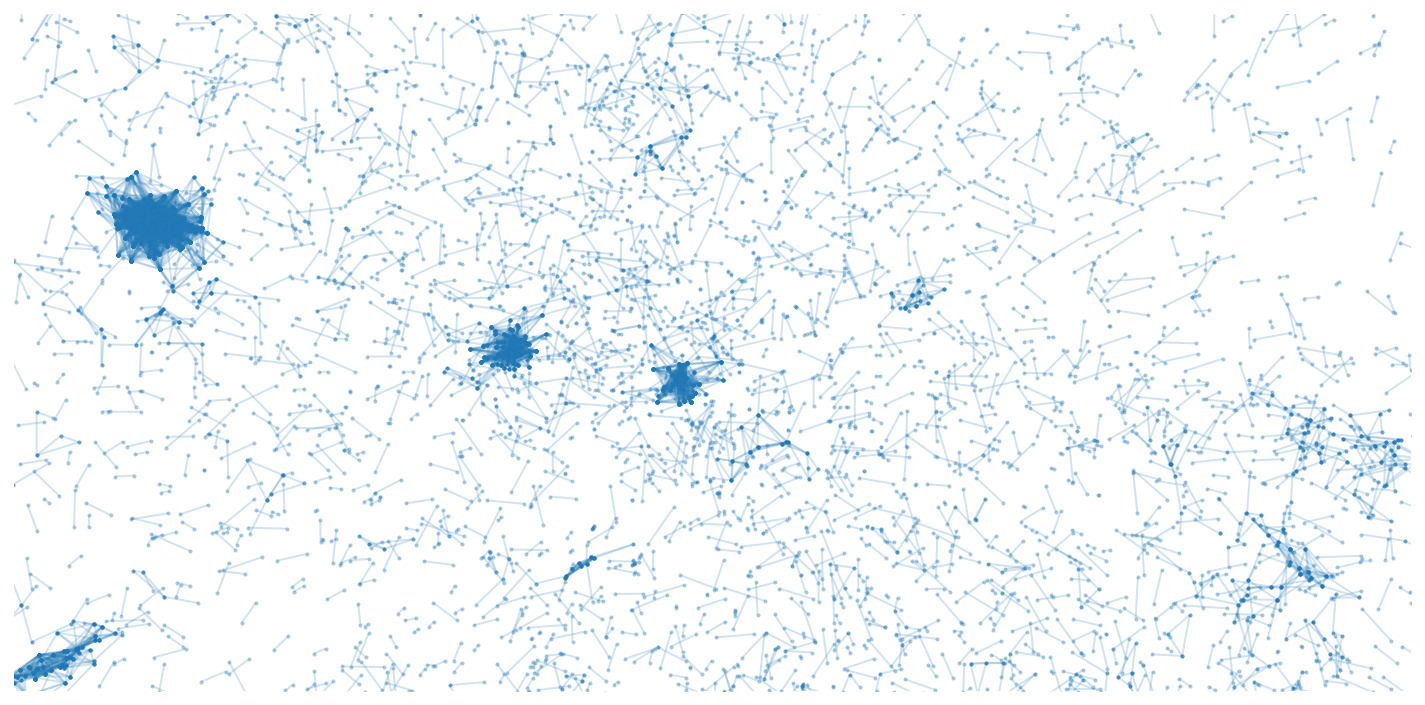

In [21]:
lim = 150

fig,ax = plt.subplots(1, 1, figsize=(10,5), frameon=False)

angles = np.arange(0, 360+1, 1)
    
lines = []
for i in range(star2_xyz.shape[1]):
    lines.append([(star1_xyz[0,i], star1_xyz[1,i]),
                  (star2_xyz[0,i], star2_xyz[1,i])]) 

lc = mpl.collections.LineCollection(lines, linestyles='-', color='tab:blue',
                                    linewidths=1, alpha=0.2)
ax.add_collection(lc)

ax.plot(star1_xyz[0], star1_xyz[1], color='tab:blue',
        marker='.', ms=4, linestyle='none', alpha=0.4)
ax.plot(star2_xyz[0], star2_xyz[1], color='tab:blue',
        marker='.', ms=4, linestyle='none', alpha=0.4)

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim/2, lim/2)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.tight_layout()

ax.axis('off')